# ADM-HW4: GROUP #10

#### Xavier Del Giudice, 


|      STUDENT       |   ID    |                 E-mail                  |
|:------------------:|:-------:|:---------------------------------------:|
| Xavier Del Giudice | 1967219 | delgiudice.1967219@studenti.uniroma1.it |
|  Flavio Mangione   |  |      |
|     Leo Rocci      |  |       |
|       |  |      |

## Import and Install required packages

In [1]:
%pip install pandas numpy scikit-learn matplotlib pyspark plotly kagglehub geopy networkx

  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Obtaining dependency information for geographiclib<3,>=1.52 from https://files.pythonhosted.org/packages/9f/5a/a26132406f1f40cf51ea349a5f11b0a46cec02a2031ff82e391c2537247a/geographiclib-2.0-py3-none-any.whl.metadata
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import os
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import networkx as nx
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time

## Import the dataset

In [2]:
# Download the dataset directly from kaggle
path = kagglehub.dataset_download("flashgordon/usa-airport-dataset")

In [3]:
df = pd.read_csv(os.path.join(path, 'Airports2.csv'))

In [4]:
df.shape

(3606803, 15)

In [5]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


In [7]:
df.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [30]:
def create_geolocator(timeout=10):
    return Nominatim(user_agent="airport_locator", timeout=timeout)

def get_lat_lon(geolocator, city, state, country, airport_code, max_retries=3):
    """
    Try to collect latitude and longitude information with different ways communicating with geolocator.
    Inputs:
    - geolocator: Nominatim geolocator
    - city: city name
    - state: state name
    - country: country name
    - airport_code: airport code
    - max_retries: maximum number of retries
    Outputs:
    - lat: latitude and lon: longitude if it's been collected successfully
    """
    
    # Try with different queries, one with the city of the airport another one with the airport code
    queries = [
        f"{city} Airport, {state}, {country}",
        f"{airport_code} Airport, {state}, {country}"
    ]

    for query in queries:
        for attempt in range(max_retries):
            try:
                location = geolocator.geocode(query)
                if location:
                    return location.latitude, location.longitude
            except (GeocoderTimedOut, GeocoderUnavailable):
                if attempt < max_retries - 1:
                    # Wait two seconds before retry
                    time.sleep(2)
                else:
                    continue
    return None, None


def update_missing_lat_lon(df):
    """"
    Function to update the NaN latitude and longitude
    Inputs:
        df: Original dataframe with missing values
    Outputs:  
        df: Updated dataframe without missing values
    """
    geolocator = create_geolocator()

    # Filter only the rows with NaN values for latitude
    # not considering also the NaN in longitude because the moves together
    df_nan_org = df[df['Org_airport_lat'].isna()]

    # Find unique combinations of origin city and origin airport to avoid to recall the OpenStreetMap API multiple times for the same request
    unique_origins = df_nan_org[['Origin_city', 'Origin_airport']].drop_duplicates()

    for _, row in unique_origins.iterrows():
        city = row["Origin_city"].split(",")[0].strip()
        state = row["Origin_city"].split(",")[-1].strip()
        country = "USA"
        airport_code = row["Origin_airport"]

        # Collect latitude and longitude
        lat, lon = get_lat_lon(geolocator, city, state, country, airport_code)

        # Update the original DataFrame respectively to the considered airport
        df.loc[(df['Origin_city'] == row['Origin_city']) & 
               (df['Origin_airport'] == row['Origin_airport']), 
               ['Org_airport_lat', 'Org_airport_long']] = lat, lon

    # Repeat the process for Destination
    df_nan_dest = df[df['Dest_airport_lat'].isna()]

    unique_destinations = df_nan_dest[['Destination_city', 'Destination_airport']].drop_duplicates()

    for _, row in unique_destinations.iterrows():
        city = row["Destination_city"].split(",")[0].strip()
        state = row["Destination_city"].split(",")[-1].strip()
        country = "USA"
        airport_code = row["Destination_airport"]

        lat, lon = get_lat_lon(geolocator, city, state, country, airport_code)
        
        df.loc[(df['Destination_city'] == row['Destination_city']) & 
               (df['Destination_airport'] == row['Destination_airport']), 
               ['Dest_airport_lat', 'Dest_airport_long']] = lat, lon

    return df

In [96]:
df.shape

(3606803, 15)

In [94]:
df = update_missing_lat_lon(df)

In [4]:
df.isnull().sum()

Origin_airport              0
Destination_airport         0
Origin_city                 0
Destination_city            0
Passengers                  0
Seats                       0
Flights                     0
Distance                    0
Fly_date                    0
Origin_population           0
Destination_population      0
Org_airport_lat           254
Org_airport_long          254
Dest_airport_lat          246
Dest_airport_long         246
dtype: int64

In [105]:
df.to_csv('final_df.csv', index=False)

## 1. Flight Network Analysis (Q1)

### Implement a function `analyze_graph_features(flight_network)` that takes the flight network as input and computes the following:
   - Count the number of airports (nodes) and flights (edges) in the graph.
   - Compute the density of the graph using the formula:  $Density = \frac{2 \cdot E}{N \cdot (N - 1)}$
   - Calculate both in-degree and out-degree for each airport and visualize them using histograms.
   - Identify airports with degrees higher than the 90th percentile and list them as "hubs."
   - Determine if the graph is sparse or dense based on its density.

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
from functions import flight_network

In [4]:
# Initialize an oriented graph
graph = nx.DiGraph()

# Add edges to the graph aggregating the routes with same origin and destination
for index, row in df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    distance = row['Distance']
    
    # If the edge has been collected yet skip
    if graph.has_edge(origin, destination):
        pass
    else:
        # Otherwise, add the new edge considering as a weight the distance between the nodes
        graph.add_edge(origin, destination, weight=distance)

In [6]:
network = flight_network.FlightNetwork(graph, df)

In [8]:
number_nodes, number_edges, denisty = network.analyze_graph_features()

The graph is dense.


Checking if the dimension of the graph are reasonable

In [12]:
all_airports = pd.concat([df['Origin_airport'], df['Destination_airport']])

unique_airports = all_airports.drop_duplicates()

num_unique_airports = unique_airports.shape[0]

print(f"Number of unique airports(nodes): {num_unique_airports}")

Numero totale di aeroporti unici: 727


In [11]:
unique_combinations = df[['Origin_airport', 'Destination_airport']].drop_duplicates()
num_unique_combinations = unique_combinations.shape[0]

print(f"Number of unique combinations(edges): {num_unique_combinations}")

Numero di combinazioni uniche: 36719


Number of nodes: 727
Number of edges: 36719
Density of the graph: 73336.984869326
Hubs (Airports with degrees higher than the 90th percentile):
 - SEA
 - PDX
 - SFO
 - LAX
 - FLL
 - PHX
 - TUS
 - DFW
 - SLC
 - RNO
 - ABQ
 - LAS
 - ICT
 - OKC
 - SAN
 - OAK
 - IAH
 - ELP
 - TUL
 - OMA
 - AUS
 - COS
 - MSN
 - RFD
 - MKE
 - DSM
 - LIT
 - SHV
 - MCI
 - SAT
 - MSP
 - ORD
 - STL
 - BNA
 - MEM
 - IND
 - LRD
 - CLE
 - DTW
 - DAY
 - CVG
 - CMH
 - FWA
 - HOU
 - TOL
 - PIT
 - BOS
 - ATL
 - MDW
 - PHL
 - GSO
 - BUF
 - EWR
 - CLT
 - JFK
 - GRR
 - YIP
 - LGA
 - LEX
 - BHM
 - MCO
 - IAD
 - MSY
 - RDU
 - GSP
 - BDL
 - CAE
 - BWI
 - TYS
 - MIA
 - TPA
 - DAL
 - JAX


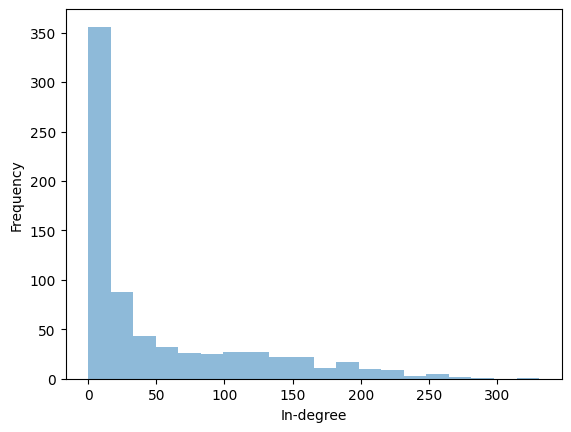

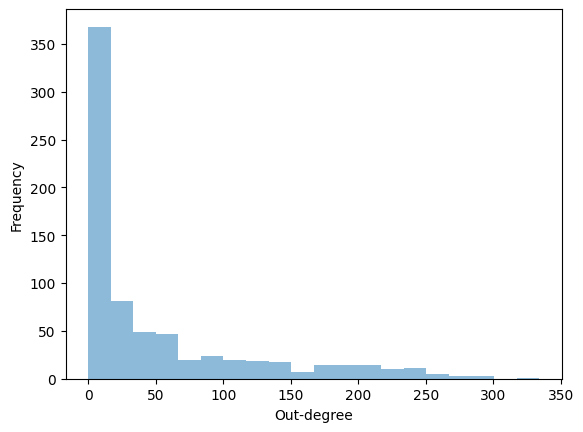

In [9]:
network.summarize_graph_features(number_nodes, number_edges, denisty)

In [5]:
from functions import interactive_map

In [6]:
#maps = interactive_map.InteractiveMap(df, graph)

In [7]:
#maps.plot()

In [13]:
import geopandas as gpd
geojson_data = gpd.read_file("us-states.json")

TEST WITH FOLIUM

In [7]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import folium
from folium.plugins import MarkerCluster
import networkx as nx
import numpy as np

# Creazione del grafo non diretto
graph = nx.Graph()

# Aggiungi nodi e archi, evitando duplicati
for index, row in df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']
    distance = row['Distance']

    # Aggiungi i nodi al grafo
    if origin not in graph:
        graph.add_node(origin,
                       pos=(row['Org_airport_long'], row['Org_airport_lat']),
                       city=row['Origin_city'],
                       state=row['Origin_city'].split(',')[1].strip())
    if destination not in graph:
        graph.add_node(destination,
                       pos=(row['Dest_airport_long'], row['Dest_airport_lat']),
                       city=row['Destination_city'],
                       state=row['Destination_city'].split(',')[1].strip())

    # Aggiungi o aggiorna l'arco
    if graph.has_edge(origin, destination):
        graph[origin][destination]['passengers'] += passengers
        graph[origin][destination]['weight'] += distance
    else:
        graph.add_edge(origin, destination, 
                       passengers=passengers, 
                       weight=distance)

# Funzione per identificare gli hub
def identify_hubs(graph):
    # Calcola il grado (in-degree + out-degree per un grafo non diretto)
    degrees = dict(graph.degree())

    # Calcola il 90° percentile dei gradi
    degree_values = list(degrees.values())
    percentile_90 = np.percentile(degree_values, 90)

    # Identifica gli hub
    hubs = [node for node, degree in degrees.items() if degree > percentile_90]
    return hubs

# Identify graph's hubs to represent it in a different way and to let filter this nodes
hubs = identify_hubs(graph)

# Creating a Dash App based on Folium, in this way we can create a web app with much more customization
# instead of running it directly in our notebook
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Map of USA Flight Network"),

    # Slider for range of passengers to consider
    html.Label("Select passengers range:"),
    dcc.RangeSlider(
        id='passenger-slider',
        min=0,
        max=200,
        step=10,
        marks={i: str(i) for i in range(0, 201, 20)},
        value=[0, 200],
    ),

    # Dropdown to filter the nodes type
    html.Label("Select Airports to visualize:"),
    dcc.Dropdown(
        id='node-filter-dropdown',
        options=[
            {'label': 'All airports', 'value': 'all'},
            {'label': 'Only hub', 'value': 'hubs'},
            {'label': 'Only not hub', 'value': 'non_hubs'}
        ],
        # Default values
        value='all',
        clearable=False,
    ),

    # Map container, HTML element where place the map
    html.Div(id='map-container')
])

# Callback function to update the map after the filtering choices
@app.callback(
    Output('map-container', 'children'),
    [Input('passenger-slider', 'value'),
     Input('node-filter-dropdown', 'value')]
)
def update_map(passenger_range, node_filter):
    # Create a folium map centered in the United States, specifying the CartoDB dark_matter tile (dark stile) 
    map = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='CartoDB dark_matter')

    # Aggiungi cluster per i marker
    marker_cluster = MarkerCluster().add_to(map)

    # Filter the airports basing on the selected filter
    if node_filter == "hubs":
        nodes_to_display = hubs
    elif node_filter == "non_hubs":
        nodes_to_display = [node for node in graph.nodes if node not in hubs]
    else:
        nodes_to_display = list(graph.nodes)

    # Add routes on the map (edges that connect each node)
    for origin, destination, data in graph.edges(data=True):
        if origin in nodes_to_display and destination in nodes_to_display:
            passengers = data['passengers']
            if passenger_range[0] <= passengers <= passenger_range[1]:
                origin_node = graph.nodes[origin]
                destination_node = graph.nodes[destination]

                # Do not consider the routes with NaN latitude and longitude
                # if we do not this, the map will not visualize raising an Exception(What type of exception?)
                if not (
                    np.isnan(origin_node['pos'][1]) or np.isnan(origin_node['pos'][0]) or 
                    np.isnan(destination_node['pos'][1]) or np.isnan(destination_node['pos'][0])
                ):
                    folium.PolyLine(
                        locations=[(origin_node['pos'][1], origin_node['pos'][0]), 
                                   (destination_node['pos'][1], destination_node['pos'][0])],
                        color='blue',
                        weight=1,
                        opacity=0.6
                    ).add_to(marker_cluster)

    # Add airports marker
    for node in nodes_to_display:
        node_data = graph.nodes[node]
        lat, lon = node_data['pos'][1], node_data['pos'][0]

        # Filter airports with NaN coordinates
        if np.isnan(lat) or np.isnan(lon):
            continue

        city = node_data['city']
        # Representation for HUB
        if node in hubs:
            folium.Marker(
                location=[lat, lon],
                # Red cloud icon
                icon=folium.Icon(color='red', icon='cloud'),
                # When you click on it, you can see its information
                popup=f"<b>HUB: {node}</b><br>{city}"
            ).add_to(marker_cluster)
        # Representation for Non-hub
        else:
            folium.Marker(
                location=[lat, lon],
                # Green info-sign icon
                icon=folium.Icon(color='green', icon='info-sign'),
                # When you click on it, you can see its information
                popup=f"<b>{node}</b><br>{city}"
            ).add_to(marker_cluster)

    # Convert the Folium map in an HTML object
    map_html = map._repr_html_()
    
    # Return the map into an HTML frame, specifying the dimension
    return html.Iframe(
        srcDoc=map_html,
        width="100%",
        height="700px"
    )

if __name__ == '__main__':
    app.run_server(jupyter_mode='external', debug=True)


Dash app running on http://127.0.0.1:8050/


In [29]:
# TO DO: Update the mean calculus
# Compute the mean of passengers for each origin and destination airport
origin_mean = df.groupby('Origin_airport')['Passengers'].mean()
destination_mean = df.groupby('Destination_airport')['Passengers'].mean()

# Concatenate the column Origin_airport and Destination_airport
all_airports = pd.concat([df['Origin_airport'], df['Destination_airport']])

# Collect all the unique airports
unique_airports = all_airports.drop_duplicates()

# Create a dictionary that contains the mean of passengers for each airport
airport_mean_passengers = {}

# Add the means for origin airports
for airport, mean in origin_mean.items():
    if airport not in airport_mean_passengers:
        airport_mean_passengers[airport] = {'origin_mean': mean, 'destination_mean': None}

# Add the means for destination airports
for airport, mean in destination_mean.items():
    if airport not in airport_mean_passengers:
        airport_mean_passengers[airport] = {'origin_mean': None, 'destination_mean': mean}

# Compute the total mean of passenger for each airport
airport_passenger_mean = {}
for airport, means in airport_mean_passengers.items():
    origin_mean = means['origin_mean']
    destination_mean = means['destination_mean']
    
    # If the airport appear as origin or destination, sum the means and compute the global mean
    if origin_mean is not None and destination_mean is not None:
        composite_mean = (origin_mean + destination_mean) / 2
    elif origin_mean is not None:
        composite_mean = origin_mean
    else:
        composite_mean = destination_mean
    
    airport_passenger_mean[airport] = composite_mean

# Initialize a directed graph (to reduce the visual load on the map)
graph = nx.Graph()

# Add nodes and edges avoiding duplicates
for index, row in df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']
    distance = row['Distance']

    # Add origin or destination airport to the graph
    if origin not in graph:
        graph.add_node(origin,
                       pos=(row['Org_airport_long'], row['Org_airport_lat']),
                       city=row['Origin_city'],
                       state=row['Origin_city'].split(',')[1].strip())
    if destination not in graph:
        graph.add_node(destination,
                       pos=(row['Dest_airport_long'], row['Dest_airport_lat']),
                       city=row['Destination_city'],
                       state=row['Destination_city'].split(',')[1].strip())

    # Add or update the edge if the edge is present
    if graph.has_edge(origin, destination):
        graph[origin][destination]['passengers'] += passengers
        graph[origin][destination]['weight'] += distance
    else:
        graph.add_edge(origin, destination, 
                       passengers=passengers, 
                       weight=distance)

# Function to identify hubs(the same as the one in flight_network.py)
# put it here to avoid the callback to the specific module
# TO DO
def identify_hubs(graph):
    # Calcola il grado (in-degree + out-degree per un grafo non diretto)
    degrees = dict(graph.degree())

    # Calcola il 90° percentile dei gradi
    degree_values = list(degrees.values())
    percentile_90 = np.percentile(degree_values, 90)

    # Identify hubs
    hubs = [node for node, degree in degrees.items() if degree > percentile_90]
    return hubs

# Identify graph's hubs to represent it in a different way and to let filter this nodes
hubs = identify_hubs(graph)

# Creating a Dash App based on Folium, in this way we can create a web app with much more customization
# instead of running it directly in our notebook
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Map of USA Flight Network"),

    # Slider for range of mean number of passengers to consider
    html.Label("Select average passengers range:"),
    dcc.RangeSlider(
        id='passenger-slider',
        min=0,
        max=7000,
        step=1000,
        marks={i: str(i) for i in range(0, 7001, 1000)},  # Visualizza i marks ogni 1000
        value=[0, 7000],
    ),

    # Dropdown to filter the nodes type
    html.Label("Select Airports to visualize:"),
    dcc.Dropdown(
        id='node-filter-dropdown',
        options=[
            {'label': 'All airports', 'value': 'all'},
            {'label': 'Only hub', 'value': 'hubs'},
            {'label': 'Only not hub', 'value': 'non_hubs'}
        ],
        value='all',
        clearable=False,
    ),

    # Map container, HTML element where place the map
    html.Div(id='map-container')
])

# Callback function to update the map after the filtering choices
@app.callback(
    Output('map-container', 'children'),
    [Input('passenger-slider', 'value'),
     Input('node-filter-dropdown', 'value')]
)
def update_map(passenger_range, node_filter):
    # Create a folium map centered in the United States, specifying the CartoDB dark_matter tile (dark stile) 
    map = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='CartoDB dark_matter')

    # Add the marker cluster (See what it do)
    marker_cluster = MarkerCluster().add_to(map)

    # Filter the airports basing on the selected filter
    if node_filter == "hubs":
        nodes_to_display = hubs
    elif node_filter == "non_hubs":
        nodes_to_display = [node for node in graph.nodes if node not in hubs]
    else:
        nodes_to_display = list(graph.nodes)

    # Add routes on the map
    for origin, destination, data in graph.edges(data=True):
        # Collect the info about the passenger mean for origin and destination
        origin_passenger_mean = airport_passenger_mean.get(origin, 0)
        destination_passenger_mean = airport_passenger_mean.get(destination, 0)
        
        # Filter if the passengers mean of the node is in the range
        if (passenger_range[0] <= origin_passenger_mean <= passenger_range[1] and
            passenger_range[0] <= destination_passenger_mean <= passenger_range[1]):
            origin_node = graph.nodes[origin]
            destination_node = graph.nodes[destination]

            # Do not consider the routes with NaN latitude and longitude
            # if we do not this, the map will not visualize raising an Exception(What type of exception?)
            if not (np.isnan(origin_node['pos'][1]) or np.isnan(origin_node['pos'][0]) or 
                    np.isnan(destination_node['pos'][1]) or np.isnan(destination_node['pos'][0])):
                folium.PolyLine(
                    locations=[(origin_node['pos'][1], origin_node['pos'][0]), 
                               (destination_node['pos'][1], destination_node['pos'][0])],
                    color='blue',
                    weight=1,
                    opacity=0.6
                ).add_to(marker_cluster)

    # Add airports marker
    for node in nodes_to_display:
        node_data = graph.nodes[node]
        lat, lon = node_data['pos'][1], node_data['pos'][0]

        # Verify if the coordinates are not NaN
        if np.isnan(lat) or np.isnan(lon):
            continue

        city = node_data['city']
        average_passengers = airport_passenger_mean.get(node, 0)

        # Check if the passengers mean is in the specified by input range
        if passenger_range[0] <= average_passengers <= passenger_range[1]:
            
        # Representation for HUBs
            if node in hubs:
                folium.Marker(
                    location=[lat, lon],
                    icon=folium.Icon(color='red', icon='cloud'),
                    popup=folium.Popup(f"<b>HUB: {node}</b><br>{city}<br>Avg Passengers: {average_passengers:.2f}", max_width=500)
                ).add_to(marker_cluster)
                
            # Representation for Non-hub
            else:
                folium.Marker(
                    location=[lat, lon],
                    # Green info-sign icon
                    icon=folium.Icon(color='green', icon='info-sign'),
                    # When you click on it, you can see its information
                    popup=folium.Popup(f"<b>{node}</b><br>{city}<br>Avg Passengers: {average_passengers:.2f}", max_width=500)
                ).add_to(marker_cluster)

    # Convert the Folium map in an HTML object
    map_html = map._repr_html_()

    # Return the map into an HTML Iframe, specifying the dimension
    return html.Iframe(
        srcDoc=map_html,
        width="100%",
        height="700px"
    )

# Run the dash app, in a web page(local)
if __name__ == '__main__':
    app.run_server(jupyter_mode='external', debug=True)

Dash app running on http://127.0.0.1:8050/


### Write a function `summarize_graph_features(flight_network)` that generates a detailed report of the graph's features. A summary report needs to include:
   - The number of nodes and edges.
   - The graph density.
   - Degree distribution plots for in-degree and out-degree.
   - A table of identified hubs.

### Now let's dive deeper into the analysis of the dataset. Do the following:
   - Compute total passenger flow between origin and destination cities.
   - Identify and visualize the busiest routes by passenger traffic.
   - Calculate the average passengers per flight for each route and highlight under/over-utilized connections.
   - Create an interactive map visualizing the geographic spread of the flight network.

### **Questions to Address:**

After completing the analysis, answer the following questions:
- Is the graph sparse or dense?
- What patterns do you observe in the degree distribution?
- Which airports are identified as hubs, and why?
- What are the busiest routes in terms of passenger traffic?
- Which routes are under/over-utilized?


## 2. Nodes' Contribution (Q2)

### Implement a function `analyze_centrality(flight_network, airport)` that computes the following centrality measures for a given airport:
   - _Betweenness centrality_: Measures how often a node appears on the shortest paths between other nodes.
   - _Closeness centrality_: Measures how easily a node can access all other nodes in the network.
   - _Degree centrality_: Simply counts the number of direct connections to the node.
   - _PageRank_: Computes the "importance" of a node based on incoming connections and their weights.

### Write a function `compare_centralities(flight_network)` to:
   - Compute and compare centrality values for all nodes in the graph.
   - Plot centrality distributions (histograms for each centrality measure).
   - Return the top 5 airports for each centrality measure.

### Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

### Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

## 3. Finding Best Routes (Q3)

### In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

## 4. Airline Network Partitioning (Q4)

### In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.

## 5. Finding and Extracting Communities (Q5)

### In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

### Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

## Bonus Question - Connected Components on MapReduce 

### In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

### Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.

## Algorithmic Question (AQ)

Arya needs to travel between cities using a network of flights. Each flight has a fixed cost (in euros), and she wants to find the cheapest possible way to travel from her starting city to her destination city. However, there are some constraints on the journey:

1. Arya can make at most `k` stops during her trip (this means up to `k+1` flights).
2. If no valid route exists within these constraints, the result should be `-1`.

Given a graph of cities connected by flights, your job is to find the minimum cost for Arya to travel between two specified cities (`src` to `dst`) while following the constraints. 

### Your Task

- **a)** Write a pseudocode that describes the algorithm to find the cheapest route with at most `k` stops. 
  
- **b)** Implement the algorithm in Python and simulate the given test cases.

- **c)** Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., `n > 100`).

- **d)** Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.

- **e)** Ask LLM (e.g., ChatGPT) for an optimized version of your algorithm. Compare its solution to yours in terms of performance, time complexity, and correctness.

### Examples

#### Example 1

**Input:**

```py
n = 4  
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]  
src = 0  
dst = 3  
k = 1  
```
**Output:**

```py
700  
```

**Explanation:**  
Arya's optimal path with at most 1 stop is `0 → 1 → 3`, costing 100 + 600 = 700 euros.  
The path `0 → 1 → 2 → 3` is cheaper but requires 2 stops, which violates the constraints.


#### Example 2

**Input:**
```py
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 1  
```
**Output:**
```py
200  
```
**Explanation:**  
Arya's optimal path with at most 1 stop is `0 → 1 → 2`, costing 100 + 100 = 200 euros.


#### Example 3

**Input:**
```py
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 0  
```
**Output:**
```py
500  
```
**Explanation:**  
Arya cannot make any stops. The only valid route is `0 → 2`, costing 500 euros.

#### Example 4

**Input:**
```py
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]]  
src = 0  
dst = 3  
k = 2  
```
**Output:**
```py
400  
```
**Explanation:**  
Arya can take `0 → 1 → 3` and `0 → 2 → 3`, however first one is cheaper, costing 400 euros.

#### Example 5

**Input:**
```py
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]  
src = 0  
dst = 3  
k = 2  
```
**Output:**
```py
400  
```
**Explanation:**  
Arya can take `0 → 1 → 3` and `0 → 2 → 3` like last example. However we have a tie, so it does not matter the route we take, the cost is still 400.